# Load quantized model

In [1]:
from tensorflow.keras.models import load_model
from deepcalo.layers import FiLM, Slice_tensor1D,Sum1D, Mask_track
from qkeras.utils import _add_supported_quantized_objects
custom_objects = {
                'Slice_tensor1D'    :   Slice_tensor1D,
                'FiLM'              :   FiLM,
                'Sum1D'             :   Sum1D,
                'Mask_track'        :   Mask_track
                }
co = {}
_add_supported_quantized_objects(co)
#model = load_model('./keras_model_binary_bnf.h5', custom_objects = co)
model = load_model('./keras_qmodel_nqbnf2.h5', custom_objects = co)
'''
from tensorflow.keras.models import Model
imgonly_model = Model(model.input[0], model.output)
imgonly_model.summary()
'''
model.summary()
from qkeras.autoqkeras.utils import print_qmodel_summary
print_qmodel_summary(model)

2022-08-27 18:09:41.450615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-27 18:09:41.450652: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-27 18:09:43.203167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-27 18:09:43.203208: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-27 18:09:43.203246: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (r7515ed520): /proc/driver/nvidia/version does not exist
2022-08-27 18:09:43.203411: I tensorflow/core/platform/cpu_feature

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
em_barrel (InputLayer)       [(None, 56, 11, 4)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 56, 55, 4)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 55, 4)         16        
_________________________________________________________________
conv2d (QConv2DBatchnorm)    (None, 56, 55, 16)        1681      
_________________________________________________________________
q_activation (QActivation)   (None, 56, 55, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 27, 16)        0         
_________________________________________________________________
conv2d_1 (QConv2DBatchnorm)  (None, 28, 27, 32)        4769

# Generate tb_data and compare the result from qkeras model

In [3]:
import numpy as np
x_test_em_barrel = np.load('x_test_em_barrel.npy')
y_test_targets = np.load('y_test_targets.npy')

from qkeras.utils import quantized_model_debug
import numpy as np
index = 19
data = x_test_em_barrel[index]
input_tb_expdim = np.expand_dims(data, axis=0)
quantized_model_debug(model, input_tb_expdim, plot=False)
print(y_test_targets[index])

input_tb = data.reshape((56*11*4))

np.savetxt('tb_input_features.dat', input_tb, fmt='%f', newline =' ')

output_tb = y_test_targets[index].reshape(1)

np.savetxt('tb_output_predictions.dat',output_tb, fmt='%f', newline =' ')

input                           -0.0113   2.2470
conv2d                          -5.5550   4.6418 ( -0.9688   0.9688) ( -0.9980   0.9980)
q_activation                     0.0000   4.6416
conv2d_1                       -10.7118  11.0684 ( -0.8125   0.7500) ( -0.9980   0.9980)
q_activation_1                   0.0000  11.0684
conv2d_2                        -9.0759   7.6755 ( -0.2188   0.2812) ( -0.9980   0.9980)
q_activation_2                   0.0000   7.6758
conv2d_3                        -7.3532   7.9246 ( -0.2812   0.2500) ( -0.9980   0.9980)
q_activation_3                   0.0000   7.9248
conv2d_4                        -8.2516   4.8531 ( -0.1562   0.0938) ( -0.9980   0.9980)
q_activation_4                   0.0000   4.8535
conv2d_5                        -5.6663   5.3525 ( -0.2812   0.2812) ( -0.9980   0.9980)
q_activation_5                   0.0000   5.3525
conv2d_6                        -3.3526   3.0998 ( -0.1250   0.1250) ( -0.9980   0.9980)
q_activation_6                   0

# Calculate the difference in qkeras model and targets

In [4]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(model.predict(x_test_em_barrel), y_test_targets)

13.890069

# Generate HLS config

In [5]:
import hls4ml
#import plotting
import pprint
#hls4ml.model.optimizer.passes.qkeras.OutputRoundingSaturationMode.layers = ['Activation']
#hls4ml.model.optimizer.passes.qkeras.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
#hls4ml.model.optimizer.passes.qkeras.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
#hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
#hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
#hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
#config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
#config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
#config['Model']['Strategy'] = 'resource'
#config['Model']['Precision'] = 'ap_fixed<16,7>'
pprint.pprint(config)


Interpreting Model
Topology:
Layer name: em_barrel, layer type: Input
Layer name: up_sampling2d, layer type: UpSampling2D
Layer name: batch_normalization, layer type: BatchNormalization
Layer name: conv2d, layer type: QConv2DBatchnorm
Layer name: q_activation, layer type: QActivation
Layer name: max_pooling2d, layer type: MaxPooling2D
Layer name: conv2d_1, layer type: QConv2DBatchnorm
Layer name: q_activation_1, layer type: QActivation
Layer name: conv2d_2, layer type: QConv2DBatchnorm
Layer name: q_activation_2, layer type: QActivation
Layer name: max_pooling2d_1, layer type: MaxPooling2D
Layer name: conv2d_3, layer type: QConv2DBatchnorm
Layer name: q_activation_3, layer type: QActivation
Layer name: conv2d_4, layer type: QConv2DBatchnorm
Layer name: q_activation_4, layer type: QActivation
Layer name: max_pooling2d_2, layer type: MaxPooling2D
Layer name: conv2d_5, layer type: QConv2DBatchnorm
Layer name: q_activation_5, layer type: QActivation
Layer name: conv2d_6, layer type: QConv2

/home/hisky/anaconda3/envs/hls4ml_as/lib/python3.8/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


# Set trace option so the output of layers can be observed

In [6]:
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True

# Finetune the precision of layers

In [7]:
quantize_precision = 'ap_fixed<16,6>'
for keys in config['LayerName']:
    if keys == 'em_barrel':
        config['LayerName'][keys]['Precision']['result'] = quantize_precision
    
    elif keys.startswith('up_sampling2d'):
        config['LayerName'][keys]['Precision'] = quantize_precision
        
    elif keys.startswith('max_pooling2d'):
        config['LayerName'][keys]['Precision'] = quantize_precision
        
    elif keys.startswith('dense') and keys.endswith('linear'):
        config['LayerName'][keys]['Precision'] = 'ap_fixed<32,16>'#quantize_precision
        
    elif keys.startswith('dense') :
        config['LayerName'][keys]['Precision']['result'] = 'ap_fixed<32,16>'#quantize_precision
        
    elif keys.startswith('conv2d') and keys.endswith('linear'):
        config['LayerName'][keys]['Precision'] = quantize_precision
        
    elif keys.startswith('conv2d'):
        config['LayerName'][keys]['Precision']['result'] = 'ap_fixed<16,6>'
        
    elif keys.endswith('quantized_relu(16, 6)'):
        config['LayerName'][keys]['Precision'] = quantize_precision
        
    elif keys.startswith('q_activation'):
        config['LayerName'][keys]['Precision']['result'] = quantize_precision
        
    elif keys.startswith('activation'):
        config['LayerName'][keys]['Precision'] = 'ap_fixed<32,16>'

# Compile

In [8]:
from tensorflow.keras import Model
#deleted_model = Model(model.input, model.get_layer('conv2d_3').output)
import hls4ml
#import plotting
import pprint
#hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
#hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
#hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

#config = hls4ml.utils.config_from_keras_model(deleted_model, granularity='Model')
#config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
#config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
config['Model']['Strategy'] = 'resource'
config['Model']['Precision'] = 'ap_fixed<32,16>'
#pprint.pprint(config)
#config['LayerName']['conv2d_batchnorm_8']['Precision']['weight'] = 'ap_fixed<16,4>'
#config['LayerName']['conv2d_batchnorm_8']['Precision']['bias'] = 'ap_fixed<16,4>'
print("-----------------------------------")
#plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='hls_qmodel/imgonly_qmodel_binary',
                                                       io_type='io_stream',
                                                       part='xcu250-figd2104-2L-e')
                                                       #part='xczu9eg-ffvb1156-2-e')
                                                       #backend='VivadoAccelerator',
                                                       #board='pynq-z2')

hls_model.compile()

-----------------------------------
-----------------------------------
Interpreting Model
Topology:
Layer name: em_barrel, layer type: InputLayer, input shapes: [[None, 56, 11, 4]], output shape: [None, 56, 11, 4]
Layer name: up_sampling2d, layer type: UpSampling2D, input shapes: [[None, 56, 11, 4]], output shape: [None, 56, 55, 4]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 56, 55, 4]], output shape: [None, 56, 55, 4]
Layer name: conv2d, layer type: QConv2DBatchnorm, input shapes: [[None, 56, 55, 4]], output shape: [None, 56, 55, 16]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 56, 55, 16]], output shape: [None, 56, 55, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 56, 55, 16]], output shape: [None, 28, 27, 16]
Layer name: conv2d_1, layer type: QConv2DBatchnorm, input shapes: [[None, 28, 27, 16]], output shape: [None, 28, 27, 32]
Layer name: q_activation_1, layer type: Activation, i

# Trace

In [9]:
hls4ml_pred, hls4ml_trace = hls_model.trace(x_test_em_barrel[:1000])
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, x_test_em_barrel[:1000])
y_hls = hls_model.predict(x_test_em_barrel)

Recompiling myproject with tracing
Writing HLS project
Done
Processing em_barrel in Keras model...
Processing up_sampling2d in Keras model...
Processing batch_normalization in Keras model...
Processing conv2d in Keras model...
Processing q_activation in Keras model...
Processing max_pooling2d in Keras model...
Processing conv2d_1 in Keras model...
Processing q_activation_1 in Keras model...
Processing conv2d_2 in Keras model...
Processing q_activation_2 in Keras model...
Processing max_pooling2d_1 in Keras model...
Processing conv2d_3 in Keras model...
Processing q_activation_3 in Keras model...
Processing conv2d_4 in Keras model...
Processing q_activation_4 in Keras model...
Processing max_pooling2d_2 in Keras model...
Processing conv2d_5 in Keras model...
Processing q_activation_5 in Keras model...
Processing conv2d_6 in Keras model...
Processing q_activation_6 in Keras model...
Processing max_pooling2d_3 in Keras model...
Processing conv2d_7 in Keras model...
Processing q_activation

In [19]:
for keys in hls4ml_trace.keys():
    print("Keras layer " + keys + ", first sample:")
    print(keras_trace[keys][0])
    print("hls4ml layer " + keys + ", first sample:")
    print(hls4ml_trace[keys][0])
    if len(keras_trace[keys][0].shape) == 1:
        np.savetxt('./trace_data/keras_trace_'+keys+'.txt', keras_trace[keys][0], fmt='%f', newline =' ')
        np.savetxt('./trace_data/hls_trace_'+keys+'.txt', hls4ml_trace[keys][0], fmt='%f', newline =' ')
    else:
        np.savetxt('./trace_data/keras_trace_'+keys+'.txt', keras_trace[keys][0][0], fmt='%f', newline =' ')
        np.savetxt('./trace_data/hls_trace_'+keys+'.txt', hls4ml_trace[keys][0][0], fmt='%f', newline =' ')
    

Keras layer up_sampling2d, first sample:
[[[0.         0.         0.00391619 0.00067286]
  [0.         0.         0.00391619 0.00067286]
  [0.         0.         0.00391619 0.00067286]
  ...
  [0.         0.         0.         0.00698311]
  [0.         0.         0.         0.00698311]
  [0.         0.         0.         0.00698311]]

 [[0.         0.         0.00391619 0.00067286]
  [0.         0.         0.00391619 0.00067286]
  [0.         0.         0.00391619 0.00067286]
  ...
  [0.         0.         0.         0.00698311]
  [0.         0.         0.         0.00698311]
  [0.         0.         0.         0.00698311]]

 [[0.         0.         0.00391619 0.00067286]
  [0.         0.         0.00391619 0.00067286]
  [0.         0.         0.00391619 0.00067286]
  ...
  [0.         0.         0.         0.00698311]
  [0.         0.         0.         0.00698311]
  [0.         0.         0.         0.00698311]]

 ...

 [[0.         0.         0.         0.        ]
  [0.         0. 

# Compare qkeras model and hls model

Processing em_barrel in Keras model...
Processing up_sampling2d in Keras model...
Processing batch_normalization in Keras model...
Processing conv2d in Keras model...


Processing q_activation in Keras model...


Processing max_pooling2d in Keras model...
Processing conv2d_1 in Keras model...
Processing q_activation_1 in Keras model...
Processing conv2d_2 in Keras model...
Processing q_activation_2 in Keras model...
Processing max_pooling2d_1 in Keras model...
Processing conv2d_3 in Keras model...
Processing q_activation_3 in Keras model...
Processing conv2d_4 in Keras model...
Processing q_activation_4 in Keras model...
Processing max_pooling2d_2 in Keras model...
Processing conv2d_5 in Keras model...
Processing q_activation_5 in Keras model...
Processing conv2d_6 in Keras model...
Processing q_activation_6 in Keras model...
Processing max_pooling2d_3 in Keras model...
Processing conv2d_7 in Keras model...
Processing q_activation_7 in Keras model...
Processing conv2d_8 in Keras model...
Processing q_activation_8 in Keras model...
Processing flatten in Keras model...
Processing dense in Keras model...
Processing batch_normalization_10 in Keras model...
Processing q_activation_9 in Keras model..

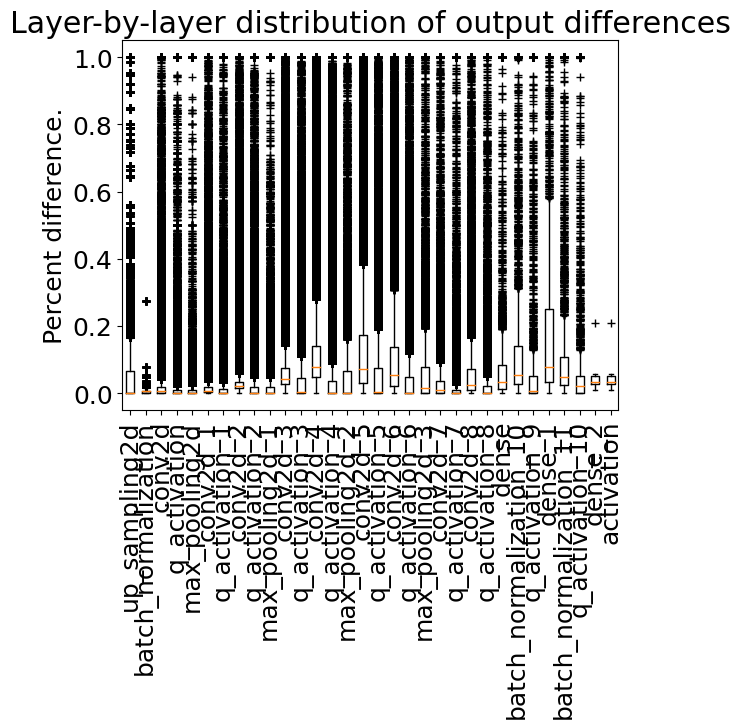

In [20]:
hls4ml.model.profiling.compare(model, hls_model, x_test_em_barrel[:10])

# Plot model 

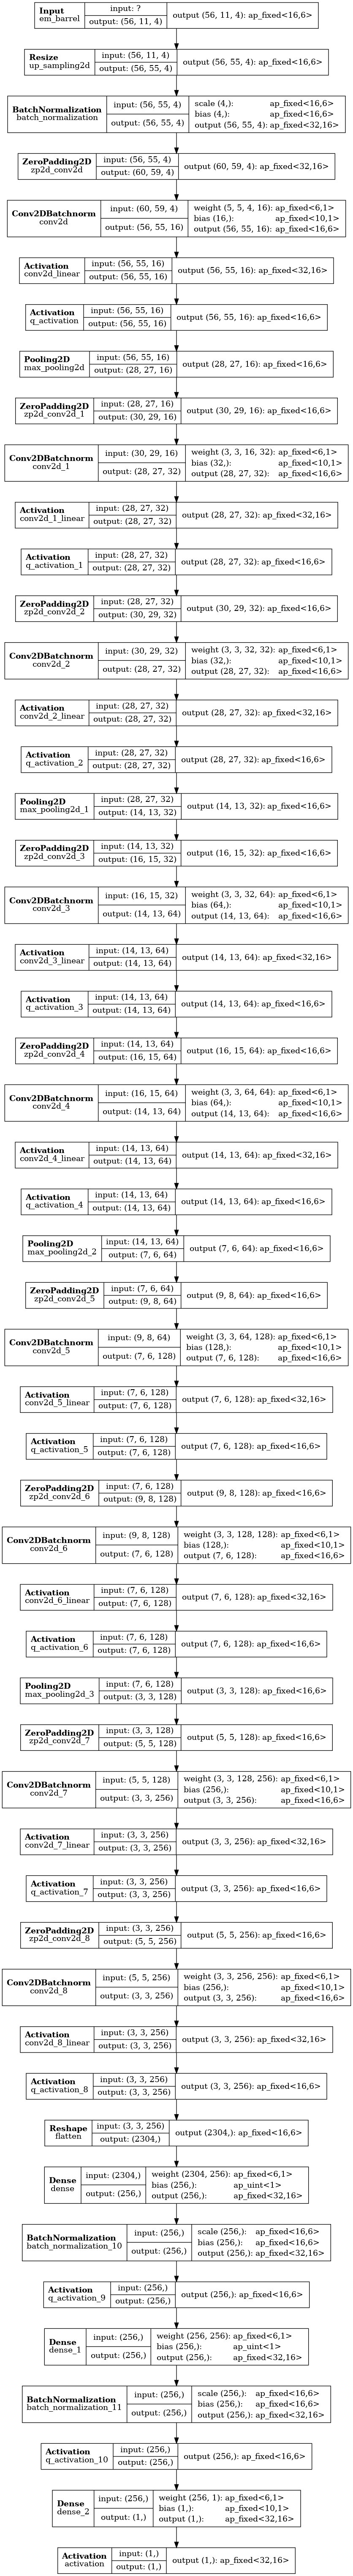

In [21]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

# Show data representing range

Interpreting Model
Topology:
Layer name: em_barrel, layer type: InputLayer, input shapes: [[None, 56, 11, 4]], output shape: [None, 56, 11, 4]
Layer name: up_sampling2d, layer type: UpSampling2D, input shapes: [[None, 56, 11, 4]], output shape: [None, 56, 55, 4]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 56, 55, 4]], output shape: [None, 56, 55, 4]
Layer name: conv2d, layer type: QConv2DBatchnorm, input shapes: [[None, 56, 55, 4]], output shape: [None, 56, 55, 16]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 56, 55, 16]], output shape: [None, 56, 55, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 56, 55, 16]], output shape: [None, 28, 27, 16]
Layer name: conv2d_1, layer type: QConv2DBatchnorm, input shapes: [[None, 28, 27, 16]], output shape: [None, 28, 27, 32]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 28, 27, 32]], output shape: [None, 28, 27, 32]
Laye

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

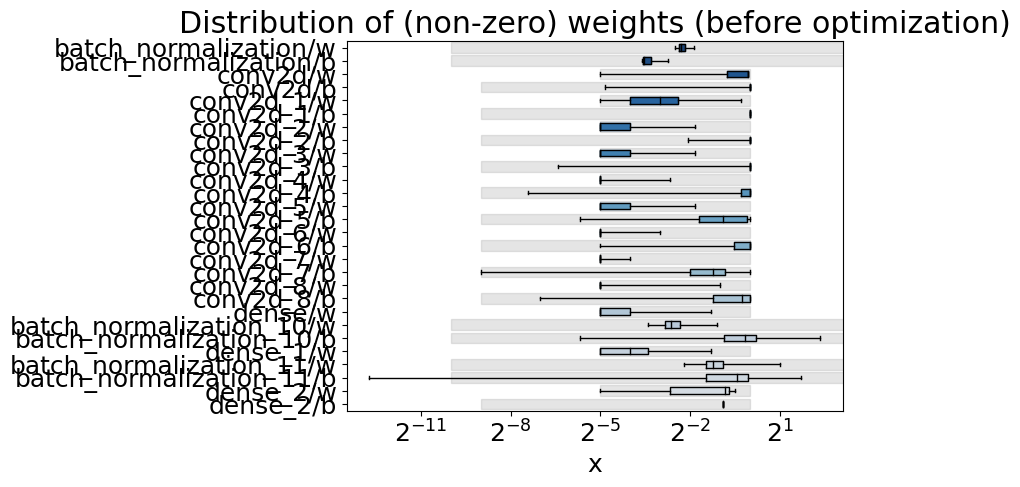

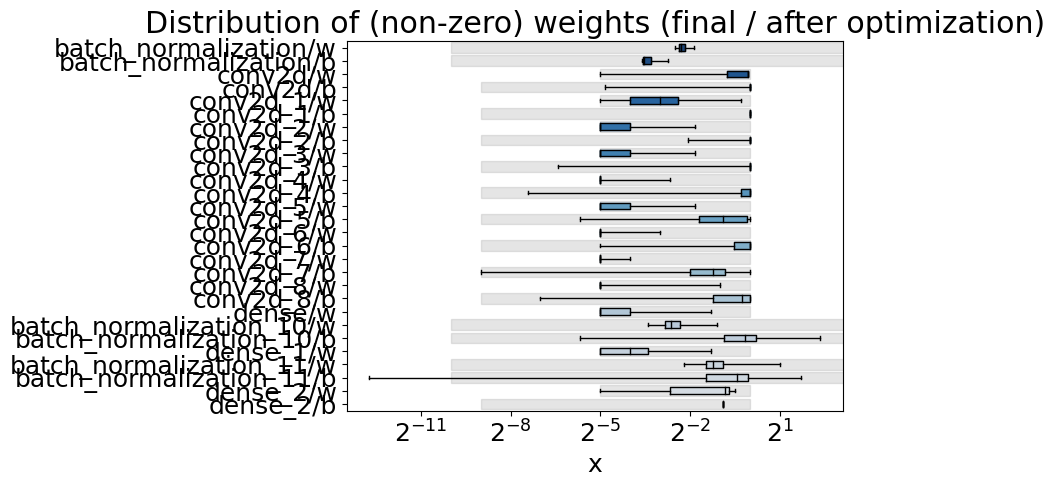

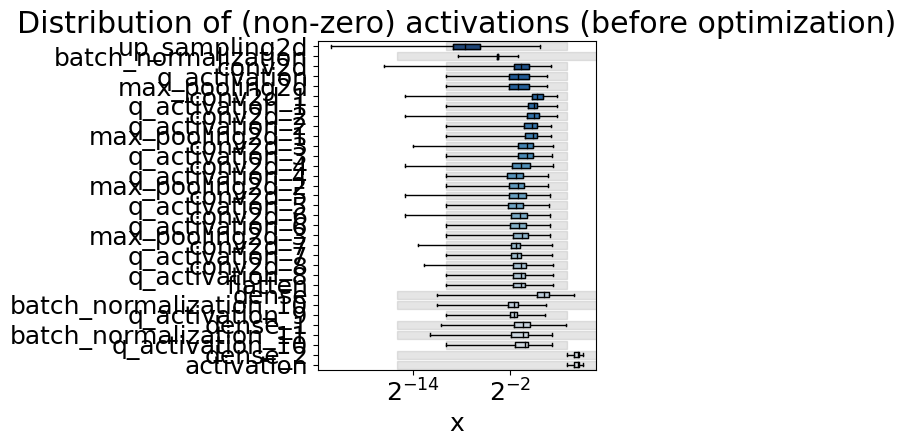

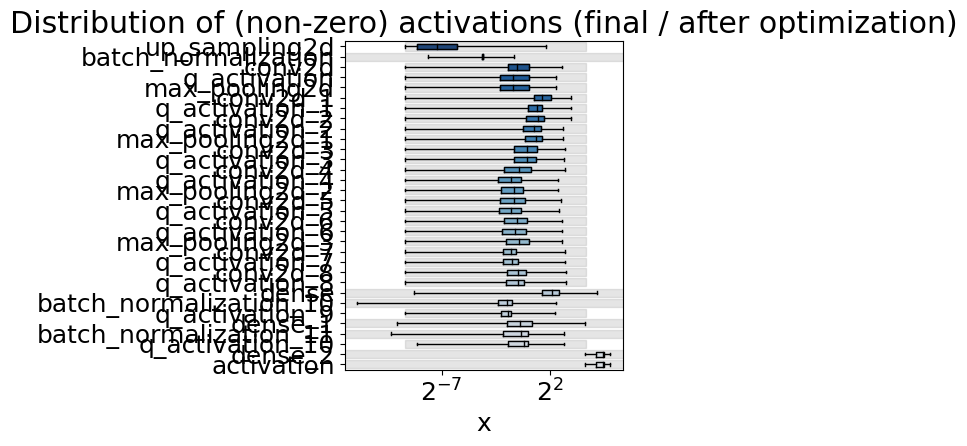

In [22]:
%matplotlib inline
#import matplotlib.pyplot as plt
#plt.figure(figsize=(6,8))
#from tensorflow.keras import Model
#deleted_model = Model(model.input, model.get_layer('conv2d_3').output)
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, 
                                 X=x_test_em_barrel[:10], plot='boxplot')

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(model.predict(x_test_em_barrel[:100]).flatten(), hls_model.predict(x_test_em_barrel[:100]).flatten())